# Importações Iniciais e criação de descritor para HOG


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, exposure

from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2

hog = cv2.HOGDescriptor((28, 28), (14, 14), (7, 7), (14, 14), 12)


# Pega dados de um arquivo de imagem e cria array numpy para guardar os resultados

In [2]:
import glob
size = 200, 200
hasPothole = []

i = 0;

potholeFolderSize = len(glob.glob('potholes/*.jpg'))

firstFileName = ""
for filename in glob.glob('potholes/*.jpg'): 
    firstFileName = filename
    break

    
im=cv2.imread(firstFileName)

im_r= cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
image_resized = cv2.resize(im_r, (size))
hogImage = hog.compute(image_resized).reshape(1, -1)


potHoleImageDimensions =hogImage.shape[1]         
    
potholeData = np.zeros((potholeFolderSize, potHoleImageDimensions))

    

# Calcula HOG para todas as imagens de buracos na pasta. Segue o seguinte processo: Lê imagem, converte para tons de cinza, redimensiona para 200x200 e por fim calcula HOG

In [3]:
i = 0;
for filename in glob.glob('potholes/*.jpg'): 
   
    
    im=cv2.imread(filename)
    #print(filename)
    im_r= cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

   
    image_resized = cv2.resize(im_r, (size))
    hasPothole.append(image_resized)
    potholeData[i] = (hog.compute(image_resized).reshape(1, -1))
    i= i + 1

# Mesmo processo acima mas para imagens sem buracos

In [4]:
normalRoadsFolderSize = len(glob.glob('normal/*.jpg'))

for filename in glob.glob('normal/*.jpg'): 
    firstFileName = filename
    break


im=cv2.imread(firstFileName)

im_r= cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
image_resized = cv2.resize(im_r, (size))
hogImage = hog.compute(image_resized).reshape(1, -1)


normalRoadsmageDimensions =hogImage.shape[1]         
    
normalRoadsData = np.zeros((normalRoadsFolderSize, normalRoadsmageDimensions))

In [5]:

i = 0;
for filename in glob.glob('normal/*.jpg'): 
   
    #print(filename)
    im=cv2.imread(filename)
   # im = np.asarray(im, dtype=np.uint8)
    
    im_r= cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

   
    image_resized = cv2.resize(im_r, (size))
    #hasPothole.append(image_resized)
    normalRoadsData[i] = (hog.compute(image_resized).reshape(1, -1))
    i= i + 1

# Cria dados para treinamento e calcula cross_val_score

In [6]:
from itertools import chain
X_train = np.array([hogData
                    for hogData in chain(potholeData,
                                    normalRoadsData)])
y_train = np.zeros(X_train.shape[0])
y_train[:potholeData.shape[0]] = 1

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.81751825, 0.88235294, 0.80882353, 0.80147059, 0.78676471])

# Efetua Grid Search e fit

In [8]:
from sklearn.svm import LinearSVC
from sklearn.model_selection  import GridSearchCV

grid = GridSearchCV(LinearSVC(dual=False,max_iter=2000), {'C': [1.0, 10.0, 100.0, 1000.0]})
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=2000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1.0, 10.0, 100.0, 1000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [9]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

# Testa classificação. 1 é buraco, 0 é ausência.

In [22]:
im=cv2.imread("potholes/115.jpg")
im_r= cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
image_resized = cv2.resize(im_r, (size))
hogP = (hog.compute(image_resized).reshape(1, -1))


In [23]:
labels = model.predict(hogP)
labels.sum()

1.0

In [12]:
im=cv2.imread("normal/1.jpg")
im_r= cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
image_resized = cv2.resize(im_r, (size))
hogP = (hog.compute(image_resized).reshape(1, -1))

labels = model.predict(hogP)
labels.sum()

0.0

# Fazendo segmentação da imagem com buraco para mostrar área... código retirado de https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rag_merge.html#sphx-glr-auto-examples-segmentation-plot-rag-merge-py

# Não é o usado por fim no artigo mas deu um resultado relativamente similar ao apresentado para imagens vistas de cima.

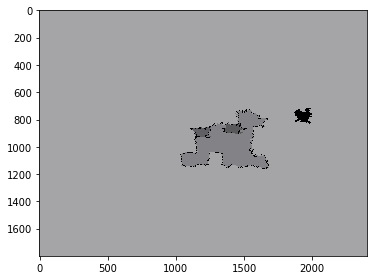

In [21]:
from skimage import data, io, segmentation, color
from skimage.future import graph
import numpy as np


def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])


img = cv2.imread("potholes/115.jpg")
labels = segmentation.slic(img, compactness=30, n_segments=400)
g = graph.rag_mean_color(img, labels)

labels2 = graph.merge_hierarchical(labels, g, thresh=40, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))
io.imshow(out)
io.show()